<a href="https://colab.research.google.com/github/katelyn-hucker/xai_hw6/blob/main/Mechanistic_Interpretability_Code_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mechanistic Interpretability

### Katie Hucker (kh509)

I used this paper as my mechanistic interpretability [reference](https://www.lesswrong.com/posts/Quqekpvx8BGMMcaem/interpreting-and-steering-features-in-images#Discovering_and_Interpreting_Features).

Visual steering is the concept of using the embedding space to find features and then **intervene** on them by changing the weights in which the features effect the image. For example, a picture of a dog and a cat could have features regarding: fluffly ears, puppies on couch, black cats. If we wanted to remove or make the dog less important in the image we could increase the strength of the feature black cats. We could also make the puppies on couch feature smaller.

Visual steering follows a similar methodology to implement and we will provide isntructions throughout this notebook as well as discussion over experiments made with visual steering.

In [142]:
from diffusers import KandinskyV22PriorPipeline, KandinskyV22Pipeline
import PIL
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import torch

In [86]:
# This code was taken from the paper used as inspiration for this assignment. Code notebook found here : https://colab.research.google.com/drive/1m6IRqKaRUWRL-d2PC82nslb7kmAgjoKV?usp=sharing#scrollTo=FxatfxVrJ9HE

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
def load_kadinsky():
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        subfolder='image_encoder'
    ).half().to(DEVICE)

    unet = UNet2DConditionModel.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        subfolder='unet'
    ).half().to(DEVICE)

    prior = KandinskyV22PriorPipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-prior',
        image_encoder=image_encoder,
        torch_dtype=torch.float16
    ).to(DEVICE)

    decoder = KandinskyV22Pipeline.from_pretrained(
        'kandinsky-community/kandinsky-2-2-decoder',
        unet=unet,
        torch_dtype=torch.float16
    ).to(DEVICE)

    zero_embed = prior.get_zero_embed()

    return prior, decoder, zero_embed


Above we have the *load_kadinsky()* function. It has 4 main components.

- **image_encoder** which uses CLIP to convert the images into numeric representations.
- **u_net** which helps generate the image and will be used to help decode.
- **prior** converts the text and/or image inputs into the latent space with help from the CLIP image encoder.
- **decoder** takes the representations generated from prior and converts them into images.

We also create a *zero_embed* variable which gets a baseline embeddings when we do not have an input.



In [ ]:
#This function was taken from the above source cited.
def load_sae():
    from huggingface_hub import snapshot_download
    model_file_path = snapshot_download(repo_id="gytdau/clip-sae-128")

    model_py_path = os.path.join(model_file_path, "model.py")
    weights_path = os.path.join(model_file_path, "sparse_autoencoder_128.pth")

    spec = importlib.util.spec_from_file_location("model_module", model_py_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)

    SparseAutoencoder = getattr(model_module, "SparseAutoencoder")

    embedding_dim = 1280
    hidden_dim = embedding_dim * 128
    model = SparseAutoencoder(embedding_dim, hidden_dim)

    state_dict = torch.load(weights_path, map_location=torch.device('cuda'))
    model.half()
    model.load_state_dict(state_dict)
    model.eval()
    model.to("cuda")

    return model

This *load_sae* loads the sparse autoencoder we will use for the model. It takes embeddings the size if 1280 which matches the kadinsky model from above. It loads the pretrained weights and information from huggingface. It will help us understand what features are in the image in a more compressed manner.  Below are the function calls, creating the prior, decoder, negative or zero embeddings, and the model.

In [88]:
#  models
prior, decoder, negative_emb = load_kadinsky()
model = load_sae()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-86-7be55a1d29d0>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cuda'))


In [87]:
#These functions were taken from the above source cited
def get_error(embed):
    encoded = model.encode(embed)
    decoded = model.decode(encoded)
    error = embed - decoded
    return error

def embed_image(item):
    return prior.interpolate([item], [1]).image_embeds[0]

def generate_one(image_embeds):
    generator = torch.Generator("cuda")
    generator.manual_seed(1)
    images = decoder(
        image_embeds=image_embeds.unsqueeze(0),
        negative_image_embeds=negative_emb,
        height=512,
        width=512,
        num_inference_steps=18,
        num_images_per_prompt=1,
        generator=generator,
    ).images

    return images[0]

def print_top_10(features):
    top_10 = features.argsort()[-10:]
    top_10 = reversed(top_10)

    for idx in top_10:
        print(f"Feature {idx:10d} = {features[idx]:.2f} (https://www.featurelab.xyz/features/{idx})")


The functions above interact with the models previously defined. The first will *embed*  the images and then we can generate one image. We also calculate *error*  which finds the differences between encoded and decoded and accounts for it in out analysis.  The *generate one image function*  takes the error and the embeded image to then decode the images.

### Intervention Experiments

The paper notes that as intervention value increase the image can degrade in quality. However, the paper does not elaborate on decreasing feature interventaion:

-  Decrease feature intervention and compare to feature invention increase; similar to paper.


The paper notes that we can also create feature tasking with steering features. Some of the tasks elaborated on include:

- changing the view of the scene
- changing the background
- finely sculpting the image.

I will explore two additional steering features that were mentioned in the paper, but were not displayed.
- Change time of day of an image, while maintaing key characteristics.

- Change the color of objects within a scene from varying color palettes. That is, do some colors features have different effect on the same image.

###  Increasing and Decreasing Feature Interventions

By changing feature intervention value, the image will change. Hopefully implementing the intended change you wanted to make on the image. We will first increase the feature value at different levels: 10, 20, 30, 40. The image used is a lady bug in nature.

In [89]:
from diffusers.utils import load_image
img=load_image("https://images.featurelab.xyz/datasets/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00053443.JPEG")

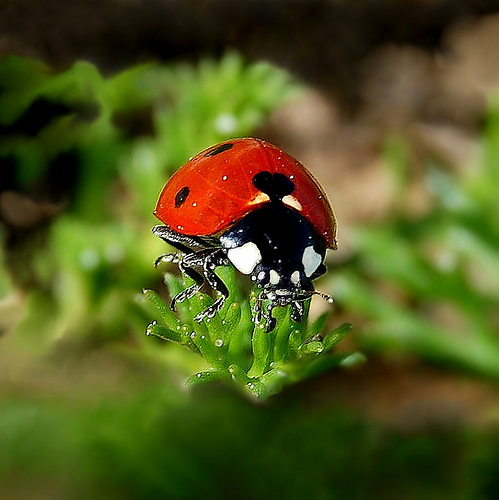

In [90]:
img

Below we embed the image using the function previously described.

In [91]:
embed = embed_image(img)

  0%|          | 0/25 [00:00<?, ?it/s]

We see the shape is correct! The embeddings should be 1280 dimensions to work with model()

In [92]:
embed.shape

torch.Size([1280])

We encode the embeddings into features so that we can make features stronger, or weaker for this image.

In [98]:
# Vivid color
# https://www.featurelab.xyz/features/84066
features = model.encode(embed)

  0%|          | 0/25 [00:00<?, ?it/s]

Here we use value strengths ranging from 10-40 to apply the feature vivid color at different strengths to the ladybug image.

In [109]:
values = [10, 20,30, 40]

results = []
for value in values:
    features_mod = features.clone() #clone so we do not keep between generations
    features_mod[84066] = value
    result = generate_one(
        model.decode(features_mod) + get_error(embed),
    )
    #Claude.ai was used at 2/19 10:03pm to generate this above for loop for saving results
    results.append(result)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

We loop through our image results from above and plot

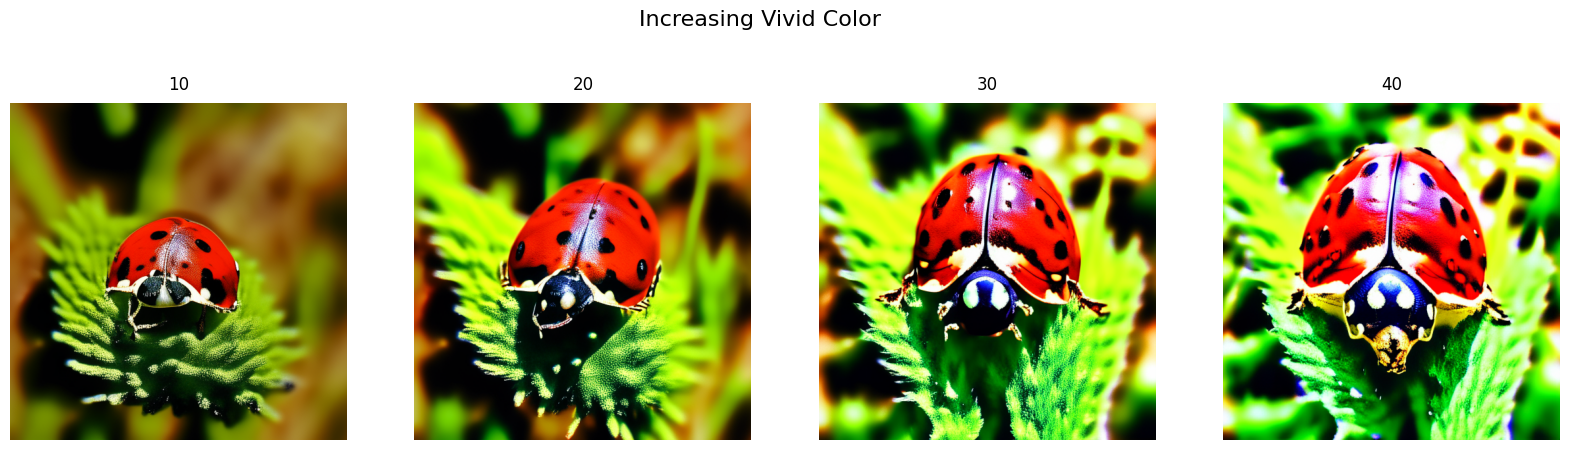

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.suptitle('Increasing Vivid Color', fontsize=16, y=1.02)

for i, (result, value) in enumerate(zip(results, values)):
    plt.subplot(1, 4, i+1)
    plt.title(str(value), pad=10)
    plt.imshow(result)
    plt.axis('off')
    #Claude.ai was used at 2/19 10:08pm to generate this for loop for plotting
plt.show()


We increase vivid color with feature intervention on the ladybug picture. This shows that the color gets brighter and the ladybug becomes more zoomed in. Similarly to the paper notes, the stronger intervention has a poorer image quality. The ladybug is too bright. The first picture enhances the ladybug's color while decreasing the the dull background. We will now decrease the vivid colors in the *original* image.

We use the same code used above but have smaller values: 5, 1, -1, -5.

In [115]:
embed = embed_image(img)
features = model.encode(embed)

values = [5, 1, -1, -5]

results = []
for value in values:
    features_mod = features.clone()
    features_mod[84066] = value
    result = generate_one(
        model.decode(features_mod) + get_error(embed),
    )#Claude.ai was used at 2/19 10:03pm generate this for loop
    results.append(result)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

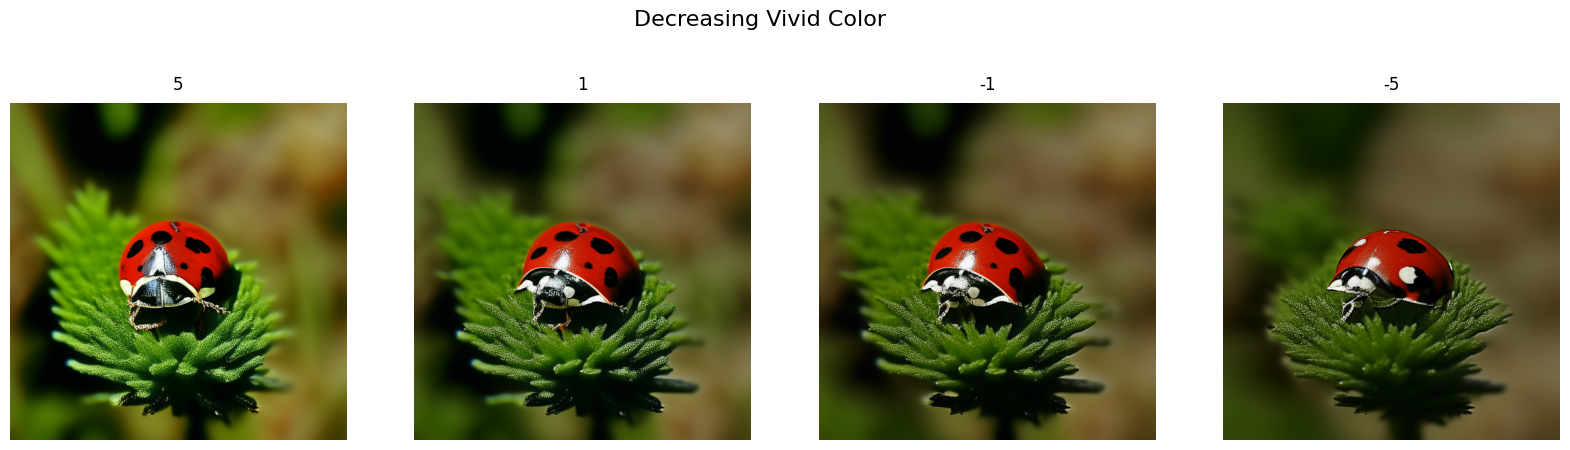

In [117]:
plt.figure(figsize=(20, 5))
plt.suptitle('Decreasing Vivid Color', fontsize=16, y=1.02)

for i, (result, value) in enumerate(zip(results, values)):
    plt.subplot(1, 4, i+1)
    plt.title(str(value), pad=10)
    plt.imshow(result)
    plt.axis('off')
    #Claude.ai was used at 2/19 10:08pm to generate this for loop for plotting
plt.show()

Above we see that as we decrease the vivid color feature the background gets darer, as well as, the shade of the lady bug gets a little darker. It is interesting that the lady bug also does not move as much than it does when we increase.

### Changing the time of day

The paper describes that users should be able to change the time of day of the image. However, they did not display results of this effect taking place. Let's try to visually steer the images from night time to day time using day time feature interventions. For this analysis we will use a picture of a city from night time.

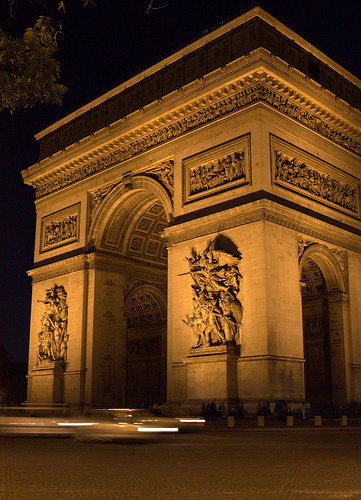

In [120]:
img = load_image("https://images.featurelab.xyz/datasets/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00044847.JPEG")
img

In [121]:
embed = embed_image(img)

  0%|          | 0/25 [00:00<?, ?it/s]

We will intervene three sunlight features at strength 15 one at a time: harsh sunlight, sharp sunny shadows, and sunlight outdoors. We encode the new image's embededdings then generate the image one by one without recreating the features.

In [127]:
features = model.encode(embed)
#Add harsh sunlight
features_mod = features.clone()
features_mod[162557] = 15
result1 = generate_one(
    model.decode(features_mod) + get_error(embed)
)

# Add sharp sunny shadows
features_mod[158377] = 15
result2 = generate_one(
    model.decode(features_mod) + get_error(embed)
)

#Add sunlight outdoors
features_mod[136018] = 15
result3 = generate_one(
    model.decode(features_mod) + get_error(embed)
)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

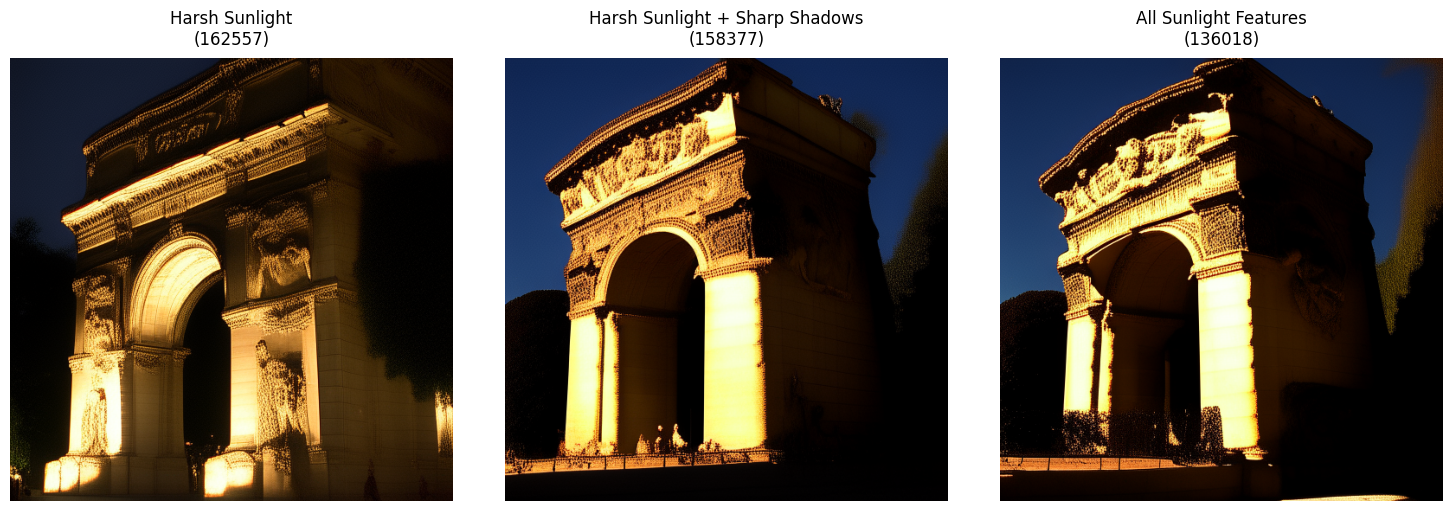

In [128]:
feature_labels = [
    "Harsh Sunlight\n(162557)",
    "Harsh Sunlight + Sharp Shadows\n(158377)",
    "All Sunlight Features\n(136018)"
]

# Create a figure with proper size
plt.figure(figsize=(15, 5))

# Plot each image with its label
for i, result in enumerate([result1, result2, result3]):
    plt.subplot(1, 3, i+1)
    plt.title(feature_labels[i], pad=10)
    plt.imshow(result)
    plt.axis('off')

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()

The paper previously mentioned that night time pictures could be turned to day time, however, as we see above from the nightime picture of the arch, it was unable to change the background. It focused on the light within the picture. The background does turn a lighter color but not to what we would expect given the features we intervened with. The image was unable to be 'steered' with enough strength. We could try changing features or increasing/decreasing intervention value to get better improvement with this goal.

### Change the color of an object: is one color easier to change to?

For this experiment, I will take an image of a red flower and intervene with vibrant purple colors, with the hope it colors the flower purple. I will also do this with the color orange.

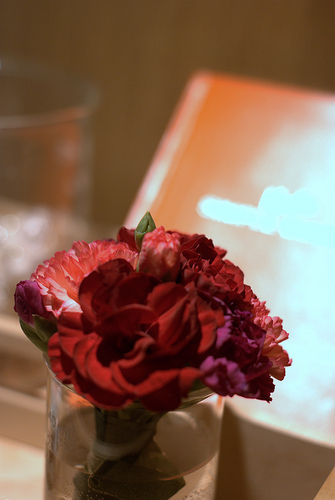

In [137]:
img=load_image("https://images.featurelab.xyz/datasets/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00040812.JPEG")
img

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

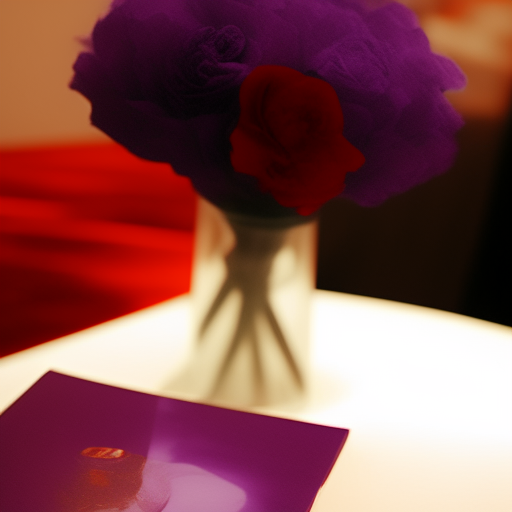

In [139]:
embed = embed_image(img)

features = model.encode(embed)

features[132193] = 15
generate_one(
    model.decode(features) + get_error(embed)
)

With the vibrant purple color feature set at strength 15, it does add some purple to the flowers in the vase as well as a purple folder. The picture did change POV and picked up some other characteristics like the folder. Next, we will try the vibrant orange colors to see if there is a similar or different effect.

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

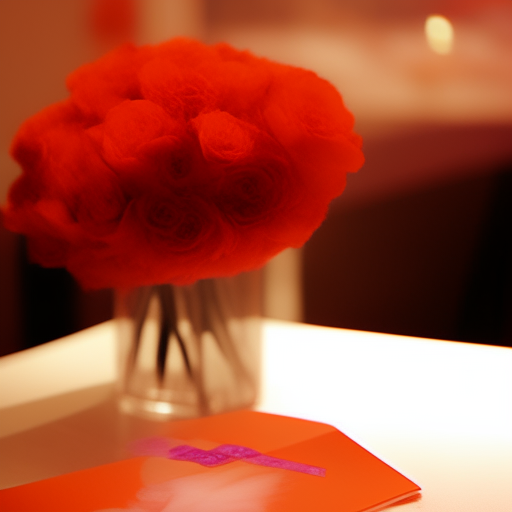

In [140]:
img=load_image("https://images.featurelab.xyz/datasets/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00040812.JPEG")
img
embed = embed_image(img)

features = model.encode(embed)

features[
18620] = 15
generate_one(
    model.decode(features) + get_error(embed)
)


With the vibrant orange color feature set at strength 15, it does add bright orange to the flowers in the vase, as well as a folder.  The picture did change POV and picked up some other characteristics like the folder. Comparatively the orange did a better job converting into the flowers than the purple did, I wonder if this is due to orange being 'closer' to red on the color wheel. Or perhaps the feature set with orange matched more closely to the flower image we used.

## Discussion

The paper discussed different improvements visual steering can be used for within the image diffusion field. I tested their claims of increasing intervention strength redcuing image quality, changing the time of day, and changing colors of images. I think their claims hold true however, it is important to note the images used can vastly change results.

The images all hold different feature embeddings and therefore have different baselines. So perhaps the ladybug would have been more sensitive to the color purple intervention as it had a lower baseline for that feature.

In addition there could be loss of information within the encodings and decodings. It would be interesting to see a similar visual steering analysis done with texts as well as images.

### Other notes

The paper states that this method should be easily convertible to other CLIP harnessed difussion methods. I personlly tried stable diffusion 1.5, Kadinsky 3, and Kadisnky 2.1. I was unable to get any of these working as the autoencoder used was very specific with required 1280 embeddings and a lot of other models were not trained at that level. I looked for other autoencoders with 768 embeddings to work with CLIP harnessed Kadisnky 2.1 and Stable diffusion. However, I was unable to find one that worked. After about 12 hours of trying to get other models to work I focused on the intervention applications rather than changing the model framework.

## References

For all images and features:
Featurelab.xyz : https://www.featurelab.xyz/

Paper (which came with the modeling set-up code):
https://www.lesswrong.com/posts/Quqekpvx8BGMMcaem/interpreting-and-steering-features-in-images#Discovering_and_Interpreting_Features

Claude AI was used for some code and is noted within the report.